In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 在通道维上连接每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [4]:
blk = DenseBlock(3, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 33, 8, 8])

In [5]:
# 3 + 10 = 13
# 13 + 10 = 23
# 23 + 10 = 33
blk

DenseBlock(
  (net): Sequential(
    (0): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(13, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Sequential(
      (0): BatchNorm2d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(23, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [6]:
# 过渡层
# 用来控制模型复杂度 ，使用 （1，1）的卷积层， 在使用平均汇聚层把高宽减半
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [7]:
blk = transition_block(33, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet

In [8]:
# 第一块和ResNet一样的单卷积层和最大汇聚层
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [9]:
num_channels, growth_rate = 64, 32
num_comvs_in_dense_block = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_comvs_in_dense_block):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    
    num_channels += num_convs * growth_rate
    # 稠密块之间添加过渡层， 最后一块后不加，使通道数减半
    if i != len(num_comvs_in_dense_block) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [10]:
net = nn.Sequential(
    b1,
    *blks,
    nn.BatchNorm2d(num_channels),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

In [11]:
X = torch.rand(1, 1, 96, 96)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 64, 24, 24])
DenseBlock output shape: 	 torch.Size([1, 192, 24, 24])
Sequential output shape: 	 torch.Size([1, 96, 12, 12])
DenseBlock output shape: 	 torch.Size([1, 224, 12, 12])
Sequential output shape: 	 torch.Size([1, 112, 6, 6])
DenseBlock output shape: 	 torch.Size([1, 240, 6, 6])
Sequential output shape: 	 torch.Size([1, 120, 3, 3])
DenseBlock output shape: 	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape: 	 torch.Size([1, 248, 3, 3])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 248, 1, 1])
Flatten output shape: 	 torch.Size([1, 248])
Linear output shape: 	 torch.Size([1, 10])


In [27]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

loss 0.141, train acc 0.948, test acc 0.891
3352.5 examples/sec on cuda:0


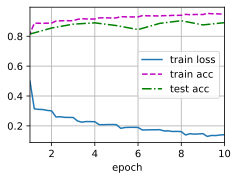

In [28]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())